In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [ ]:
data = pd.read_csv("AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Первый взгляд на данные

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Удалим часть признаков, поскольку они являются технической информацией: `id`, `name`, `host_id`, `host_name`. А также избавимся от фичи `last_review`, поскольку на данном этапе мы не знаем, как работать с текстом.

In [ ]:
data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)

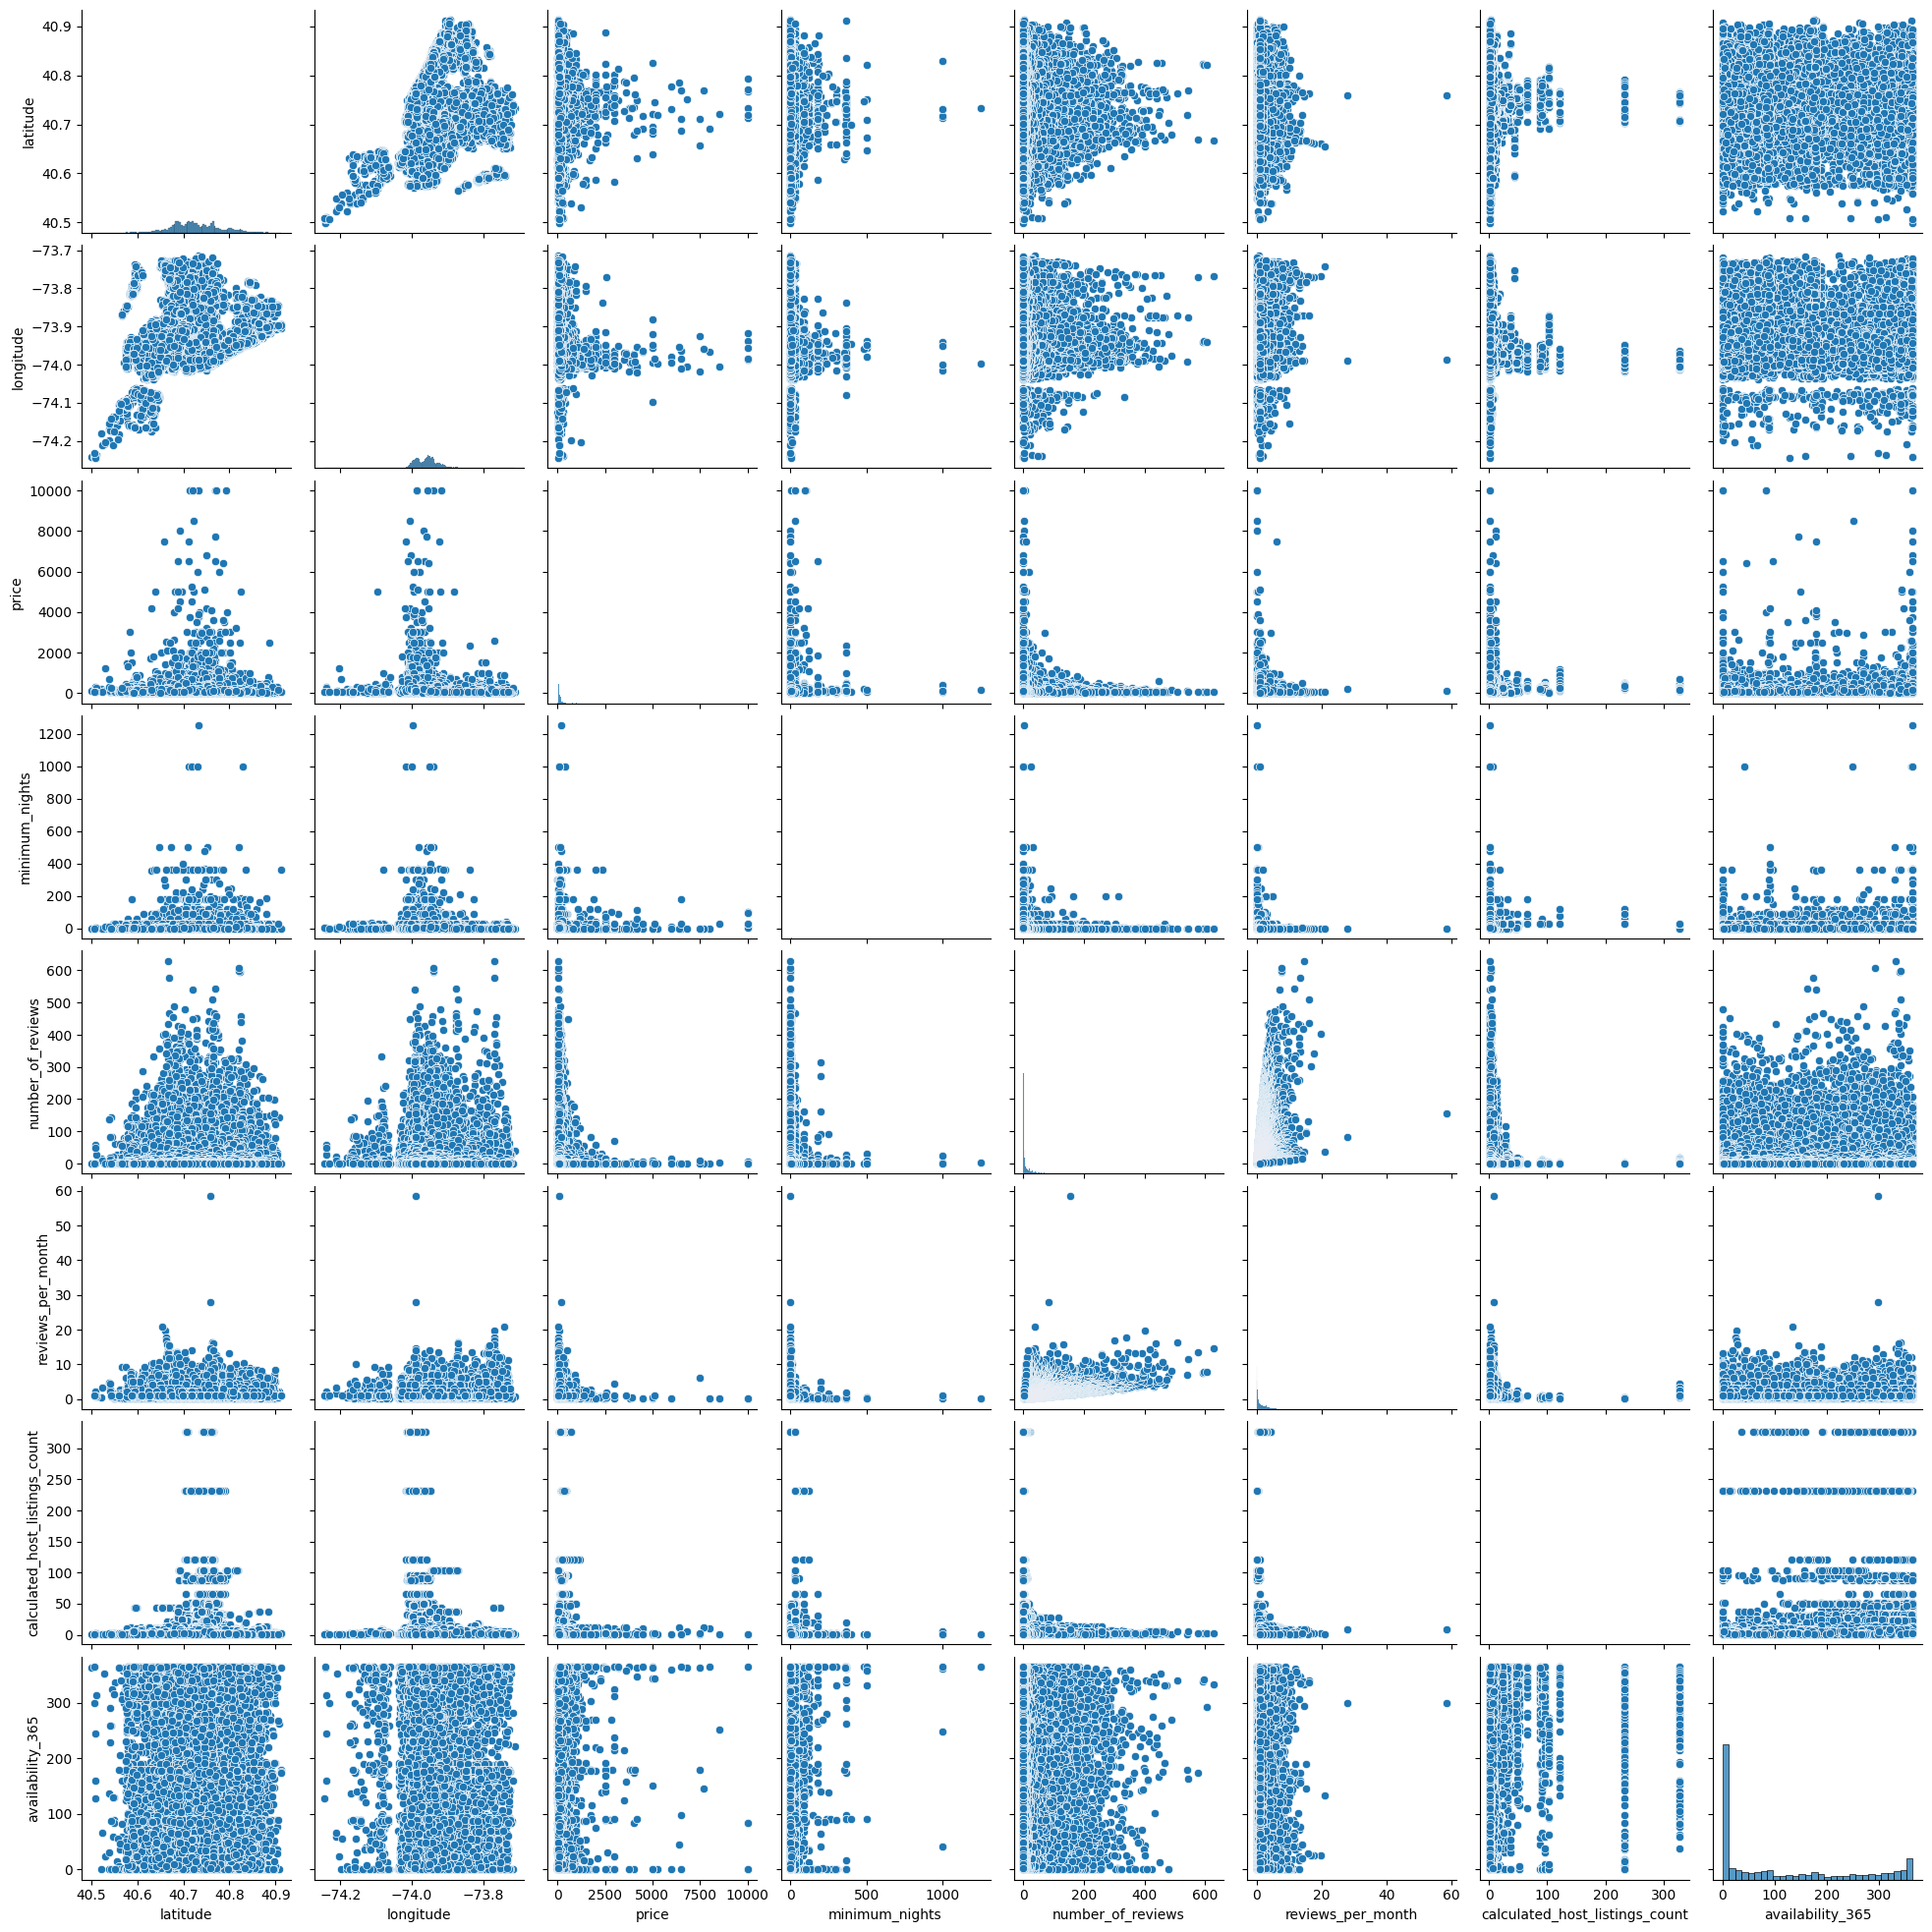

In [ ]:
sns.pairplot(data);

Данных много, однако сильных линейных связей между атрибутами таблицы не наблюдается (кроме `longitude` и `latitude`, но эта взаимосвязь очевидна).



## Предобработка данных
### Восстановление пропущенных значений
Необходимо исследовать представленные данные на наличие пропущенных значений и по возможности восстановить целостность данных.

In [ ]:
(data.isnull().sum() / data.shape[0]) * 100

,0
neighbourhood_group,0.000000
neighbourhood,0.000000
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,0.000000
minimum_nights,0.000000
number_of_reviews,0.000000
reviews_per_month,20.558339
calculated_host_listings_count,0.000000


Имеется 20.5% пропущенных значений в атрибуте `reviews_per_month`. Без сомнения, атрибут важный, поэтому постараемся сохранить данные и восстановить утерянную информацию.

Поскольку у нас нет атрибута, отвечающего за некоторую периодичность, но есть атрибут, отвечающий за общее количество отзывов. Из контекстной справки к данным на kaggle мы знаем, что данные представлены за период с 2008 по 2019 гг. Можно сделать **наивное предположение**, что все объекты недвижимости, не имеющие значения в столбце `reviews_per_month`, были добавлены в таблицу в конце этого периода. Тогда попробуем восстановить целостность и сравнить получившиеся распределения.

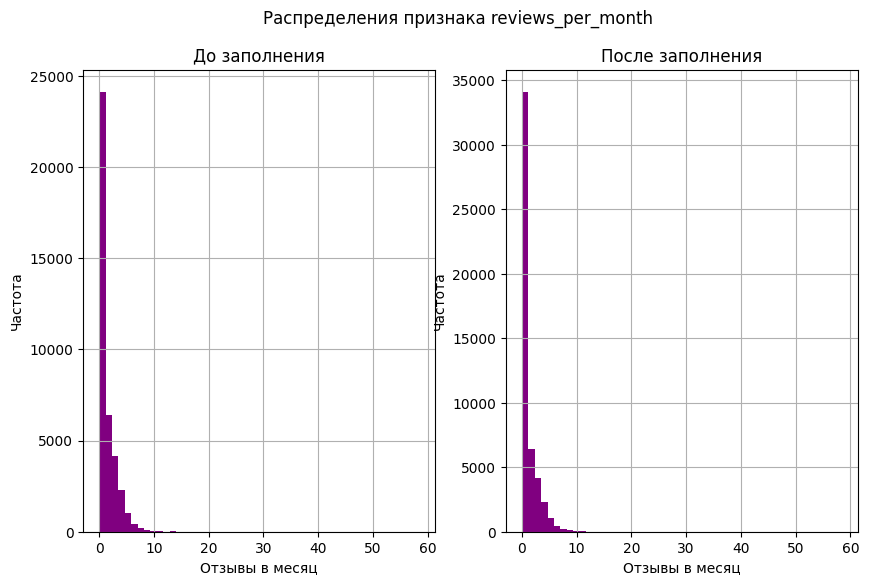

48.61111111111111% составило изменение медианы


In [ ]:
# сколько месяцев было в периоде
months_difference = (2019-2008) * 12

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
plt.suptitle("Распределения признака reviews_per_month")
data['reviews_per_month'].hist(bins=50, color='purple', ax=ax[0]);
ax[0].set_title("До заполнения")
ax[0].set_xlabel("Отзывы в месяц")
ax[0].set_ylabel("Частота")
test_reviews = data[['reviews_per_month', 'number_of_reviews']].copy()
test_reviews['reviews_per_month'] = test_reviews.apply(lambda x: x['reviews_per_month'] \
                   if not np.isnan(x['reviews_per_month']) \
                   else x['number_of_reviews'] / months_difference, axis=1)
ax[1].set_title('После заполнения')
ax[1].set_xlabel("Отзывы в месяц")
ax[1].set_ylabel("Частота")
test_reviews['reviews_per_month'].hist(bins=50, color='purple', ax=ax[1])
plt.show();
print(f"{(np.abs(data['reviews_per_month'].median() - test_reviews['reviews_per_month'].median())/data['reviews_per_month'].median()) * 100}% составило изменение медианы")

Как видим, медианы распределений не совпадают, причём различие значительное. Поэтому попробуем другой способ: сгруппируем все наблюдения по группам и попробуем заполнить пропуски медианами этих групп.

Попробуем предположить, что количество отзывов зависит от нахождения объекта недвижимости в группе, формируемой атрибутами `neighbourhood_group`, `neighbourhood`, `room_type`.



In [ ]:
old_median = data['reviews_per_month'].median()
data['reviews_per_month'] = data.groupby(['neighbourhood_group',
                                          'neighbourhood', 'room_type'])['reviews_per_month'].transform(lambda x: x.fillna(x.median()))
new_median = data['reviews_per_month'].median()
print(f"{(np.abs(old_median - new_median)/old_median) * 100}% составило изменение медианы")
data.isnull().sum()

8.333333333333325% составило изменение медианы


,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,37
calculated_host_listings_count,0


Остались 37 пропущенных значения, поскольку в пределах некоторой группы не нашлось вещественных значений для расчёта медианы. Небольшой процент пропусков $-$ можем удалить.

In [ ]:
data.dropna(inplace=True)
data.isnull().sum()

,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,0
calculated_host_listings_count,0


### Поиск аномалий и выбросов
Из всех признаков аномалии следует искать в атрибутах `minimum_nights` и `reviews_per_month`. От атрибута `number_of_reviews`, в принципе, можно избавиться, поскольку его вклад есть уже в атрибуте `reviews_per_month`.

In [ ]:
# удалить number_of_reviews
data.drop(columns=['number_of_reviews'], inplace=True)
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0.79,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,0.10,1,0


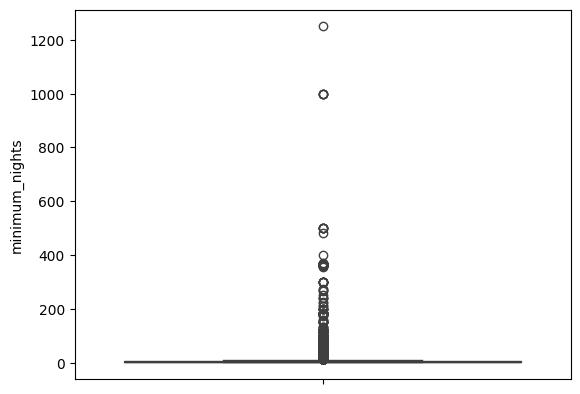

In [ ]:
# minimum_nights
sns.boxplot(data['minimum_nights'])
plt.show();

На самом деле, выглядит так, словно к значениям приписали несколько лишних нолей справа и забыли поставить запятую. Поскольку 3-й квартиль равен 5, то максимальное значение должно быть в пределах 10-12.

In [ ]:
Q1 = np.percentile(data['minimum_nights'], 25)
Q3 = np.percentile(data['minimum_nights'], 75)
IQR = Q3 - Q1
print(f"Максимальное возможное минимальное количество ночей равно {Q3 + 1.5 * IQR}")
print(f"Экстремально максимальное возможное минимальное количество ночей равно {Q3 + 3 * IQR}")

Максимальное возможное минимальное количество ночей равно 11.0
Экстремально максимальное возможное минимальное количество ночей равно 17.0


In [ ]:
len(data[data['minimum_nights'] > 11]) / data.shape[0] * 100

13.520815424290802

In [ ]:
len(data[data['minimum_nights'] > 17]) / data.shape[0] * 100

11.437226247492733

Будем предполагать, что дольше 17 ночей остаться нельзя. Заменим все значения, превышающие 17, на 17.

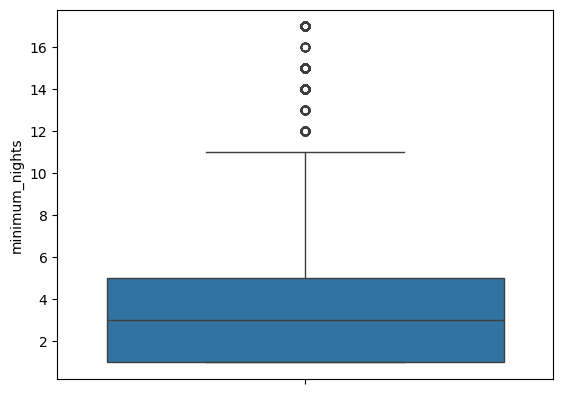

In [ ]:
data.loc[data['minimum_nights'] > 17, 'minimum_nights'] = 17
sns.boxplot(data['minimum_nights'])
plt.show();

Да, у нас остаются экстремально превышающие значения, но оставим пока в таком виде. Вероятно, они отпадут при дальнейшей очистке данных.

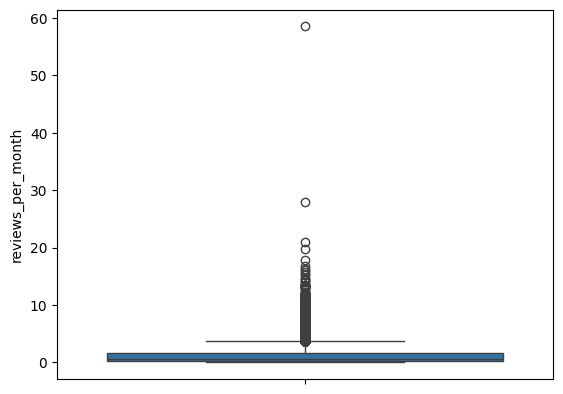

In [ ]:
# reviews_per_month
sns.boxplot(data['reviews_per_month'])
plt.show();

In [ ]:
Q1 = np.percentile(data['reviews_per_month'], 25)
Q3 = np.percentile(data['reviews_per_month'], 75)
IQR = Q3 - Q1
print(f"Максимальное возможное количество отзывов в месяц равно {Q3 + 1.5 * IQR}")
print(f"Экстремально максимальное возможное количество отзывов в месяц равно {Q3 + 3 * IQR}")

Максимальное возможное количество отзывов в месяц равно 3.745
Экстремально максимальное возможное количество отзывов в месяц равно 5.83


In [ ]:
len(data[data['reviews_per_month'] > 3.745]) / data.shape[0] * 100

7.444021449916082

In [ ]:
len(data[data['reviews_per_month'] > 5.83]) / data.shape[0] * 100

1.7847640099881288

Делаю замену экстремально превышающих значений количества отзывов в месяц на величину $Q3 + 3*IQR$.

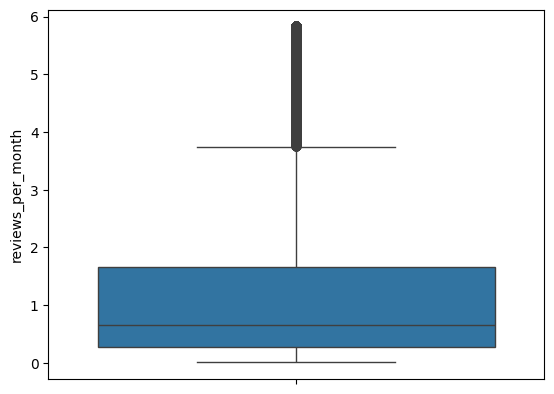

In [ ]:
data.loc[data['reviews_per_month'] > 5.83, 'reviews_per_month'] = 5.83
sns.boxplot(data['reviews_per_month'])
plt.show();

In [ ]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0.79,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,0.10,1,0


Сами по себе координаты не несут полезной нагрузки, однако на их основе можно создать дополнительный признак. Вычислим через евклидовое расстояние расстояние от объекта недвижимости до центра Нью-Йорка.


In [ ]:
center_coordinates = (40.71427, -74.00597)
data['center_distance'] = data.apply(lambda x: np.sqrt((x['latitude'] - center_coordinates[0])**2 + (x['longitude'] - center_coordinates[1])**2), axis=1)
data.drop(columns=['latitude', 'longitude'], inplace=True)
data.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
0,Brooklyn,Kensington,Private room,149,1,0.21,6,365,0.074756
1,Manhattan,Midtown,Entire home/apt,225,1,0.38,2,355,0.045180
2,Manhattan,Harlem,Private room,150,3,0.79,1,365,0.114379
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,4.64,1,194,0.054625
4,Manhattan,East Harlem,Entire home/apt,80,10,0.10,1,0,0.104584


### Категориальные признаки
В представленной выборке имеется три категориальных признака: `neighbourhood_group`, `neighbourhood`, `room_type`. На этом этапе принимается решение об удалении атрибута `neighbourhood`, поскольку он содержит наименования микрорайонов, но в выборке уже есть более плотно сгруппированный атрибут  $-$ `neighbourhood_group`.

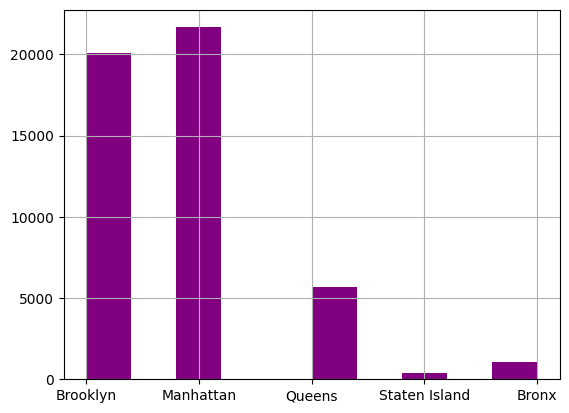

In [ ]:
data.drop(columns=['neighbourhood'], inplace=True)
plt.grid(False)
data['neighbourhood_group'].hist(color='purple');

Имеются две очень редко встречающиеся категории: `Staten Island` и `Bronx`. Чтобы не вносить лишние зависимости, принимается решение объединить обе категории в одну.


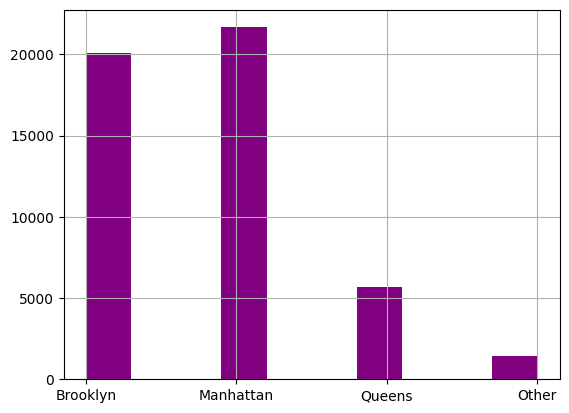

In [ ]:
data['neighbourhood_group'] = data['neighbourhood_group'].apply(lambda x: 'Other' if x in ['Staten Island', 'Bronx'] else x)
data['neighbourhood_group'].hist(color='purple');

In [ ]:
# вынесем их в отдельные атрибуты
neighbourhood_groop_cats = pd.get_dummies(data['neighbourhood_group'], prefix='neighbourhood_group').astype(np.int8)
data = pd.concat([data.drop(['neighbourhood_group'], axis=1), neighbourhood_groop_cats], axis=1)
data.head()

,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,center_distance,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Other,neighbourhood_group_Queens
0,Private room,149,1,0.21,6,365,0.074756,1,0,0,0
1,Entire home/apt,225,1,0.38,2,355,0.045180,0,1,0,0
2,Private room,150,3,0.79,1,365,0.114379,0,1,0,0
3,Entire home/apt,89,1,4.64,1,194,0.054625,1,0,0,0
4,Entire home/apt,80,10,0.10,1,0,0.104584,0,1,0,0


Рассмотрим атрибут `room_type`.


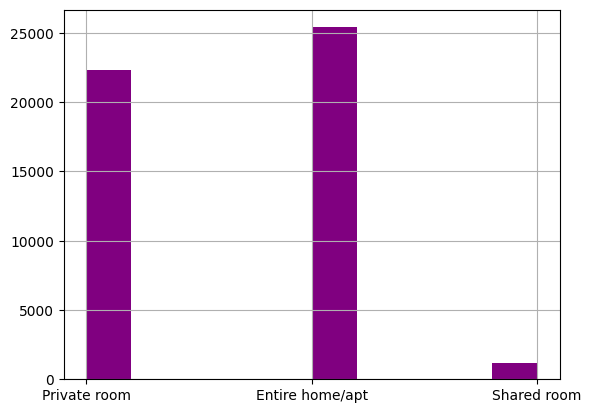

In [ ]:
plt.grid(False)
data['room_type'].hist(color='purple')
plt.show();


Можно заметить, что чаще всего сдаются либо квартира/дом целиком, либо отдельная комната. Койко-места предлагают гораздо реже. Принимается решение оставить категорию в выборке, но в будущем есть вероятность, что придётся отказаться.

In [ ]:
# вынесем их в отдельные атрибуты
room_types_cats = pd.get_dummies(data['room_type'], prefix='room_type').astype(np.int8)
data = pd.concat([data.drop(['room_type'], axis=1), room_types_cats], axis=1)
data.head()

,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,center_distance,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Other,neighbourhood_group_Queens,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,0.21,6,365,0.074756,1,0,0,0,0,1,0
1,225,1,0.38,2,355,0.045180,0,1,0,0,1,0,0
2,150,3,0.79,1,365,0.114379,0,1,0,0,0,1,0
3,89,1,4.64,1,194,0.054625,1,0,0,0,1,0,0
4,80,10,0.10,1,0,0.104584,0,1,0,0,1,0,0


### Шкалирование данных

Нужно заметить, что на этом этапе все признаки находятся в разных шкалах, что для линейных моделей может стать существенным препятствием во время обучения. Прошкалируем все данные, сократив разброс осей.

In [ ]:
from sklearn.preprocessing import robust_scale
X = data.drop(columns=['price'])
y = data['price']
X = pd.DataFrame(robust_scale(X), columns=X.columns)
data.head()

,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,center_distance,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Other,neighbourhood_group_Queens,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,0.21,6,365,0.074756,1,0,0,0,0,1,0
1,225,1,0.38,2,355,0.045180,0,1,0,0,1,0,0
2,150,3,0.79,1,365,0.114379,0,1,0,0,0,1,0
3,89,1,4.64,1,194,0.054625,1,0,0,0,1,0,0
4,80,10,0.10,1,0,0.104584,0,1,0,0,1,0,0


In [ ]:
print(len(X), len(y))

48858 48858


## Построение модели
### Проверка на мультиколлинеарность
Посмотрим на получившуюся выборку, оценив корреляции между атрибутами.

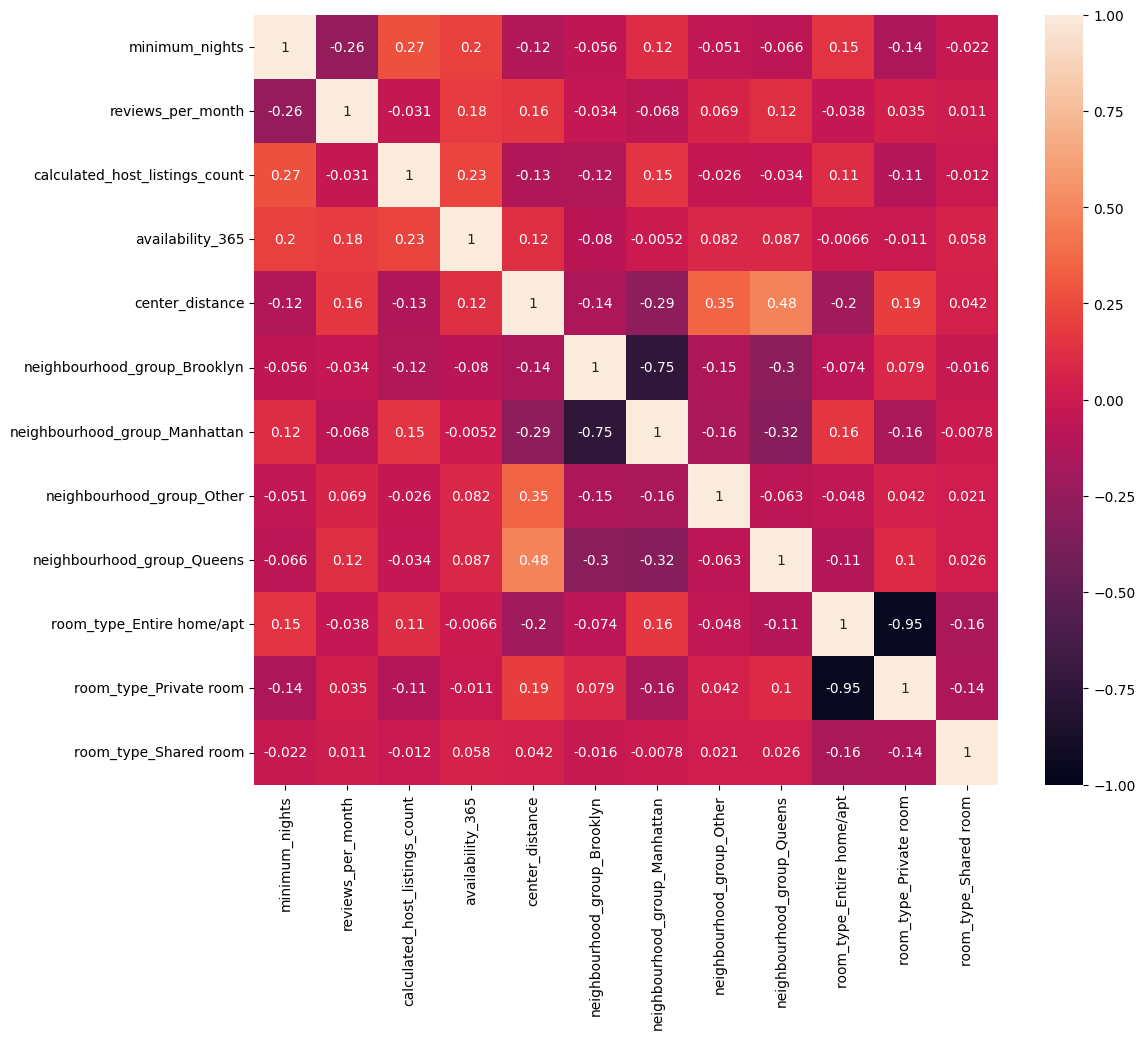

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, vmin=-1, vmax=1);

In [ ]:
threshold = .6
high_corr_pairs = [(i, j) for i in X.corr().columns for j in X.corr().columns
                   if i != j and abs(X.corr().loc[i, j]) > threshold]
high_corr_pairs

[('neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan'),
 ('neighbourhood_group_Manhattan', 'neighbourhood_group_Brooklyn'),
 ('room_type_Entire home/apt', 'room_type_Private room'),
 ('room_type_Private room', 'room_type_Entire home/apt')]

Итак, поскольку при one hot encoding'е я не отбрасывал одну из категорий, у меня появилась мультиколлинеарность в выборке. Принимается решение избавиться от атрибутов `room_type_Entire home/apt`, поскольку модель будет определять, какую именно комнату сдают (если ни то, ни другое, то это частный дом), а также атрибут `neighbourhood_group_Brooklyn` (тут особой логики нет, просто не понравился).

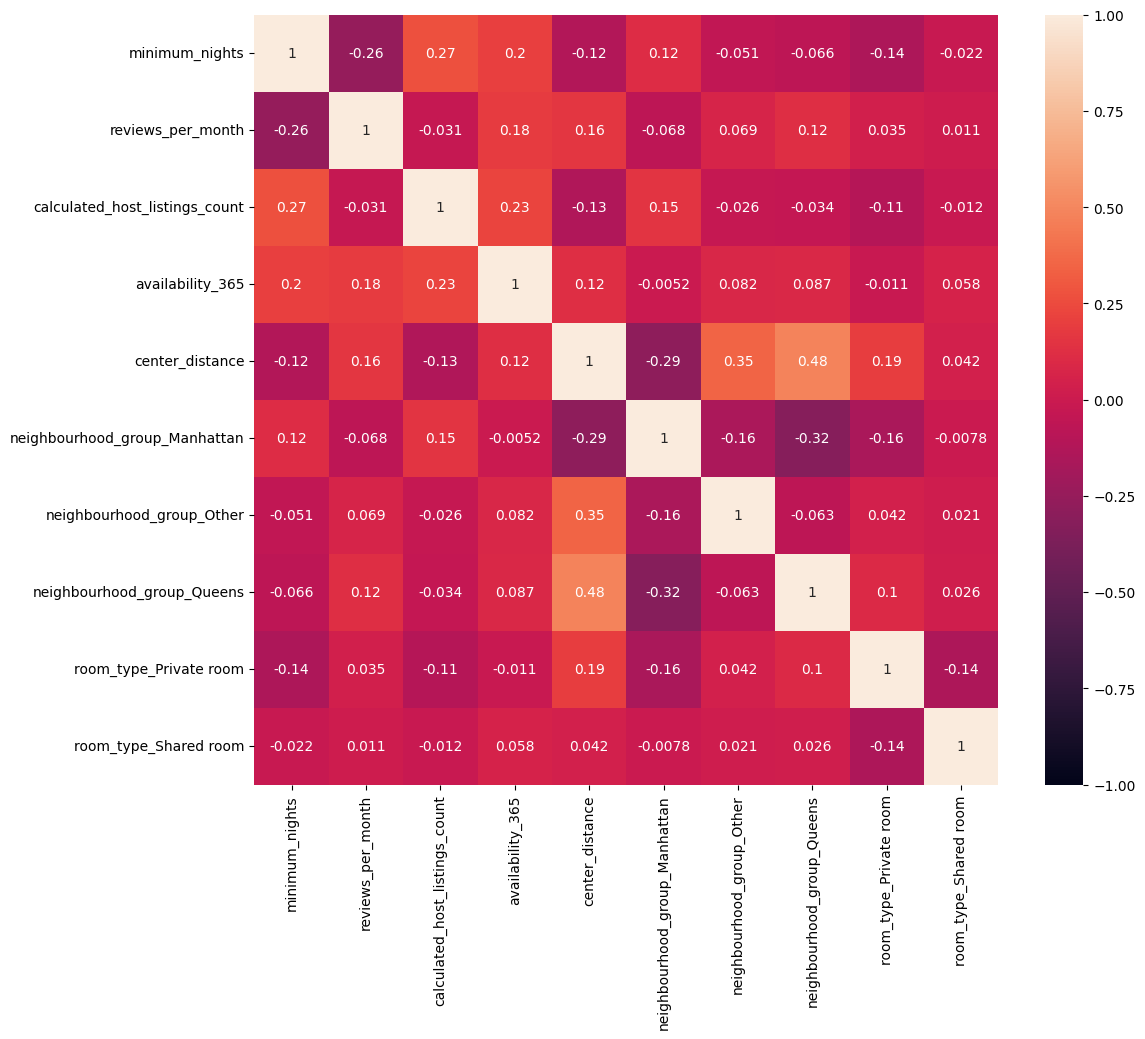

In [ ]:
X.drop(columns=['neighbourhood_group_Brooklyn', 'room_type_Entire home/apt'], inplace=True)
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, vmin=-1, vmax=1);

### Анализ целевой переменной
Необходимо проанализировать распределение цен на объекты недвижимости.

In [ ]:
y.describe()

,price
count,48858.000000
mean,152.742355
std,240.202704
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


Будем считать, что минимальная цена комнаты составляет 50 долларов.

In [ ]:
X.drop(index=np.where(y == 0)[0], inplace=True)
len(X)

48847

In [ ]:
y = y[y > 0]
len(y)

48847

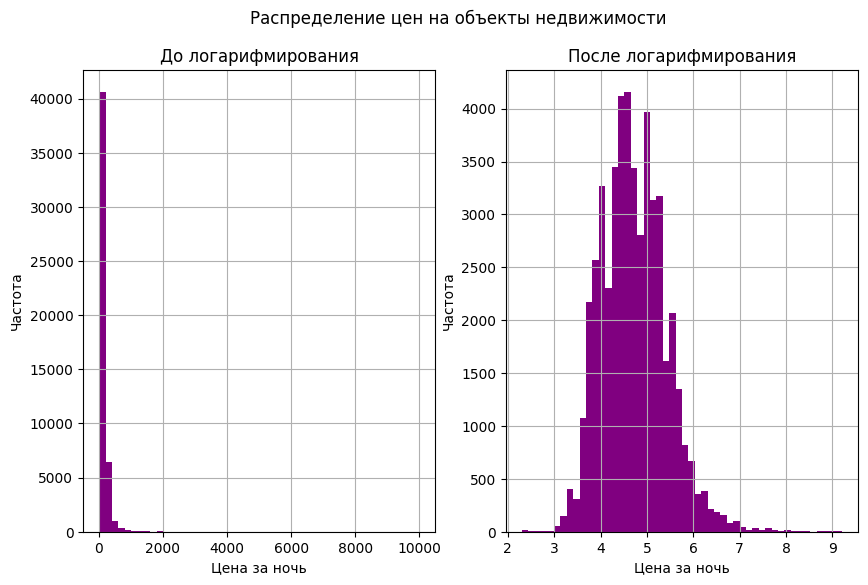

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
fig.suptitle("Распределение цен на объекты недвижимости")
ax[0].set_title("До логарифмирования")
ax[0].set_xlabel("Цена за ночь")
ax[0].set_ylabel("Частота")
y.hist(bins=50, color='purple', ax=ax[0]);
ax[1].set_title("После логарифмирования")
ax[1].set_xlabel("Цена за ночь")
ax[1].set_ylabel("Частота")
np.log(y).hist(bins=50, color='purple', ax=ax[1]);
plt.show();

In [ ]:
y = np.log(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

### Обучение и оценка моделей

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# функция для получения метрик модели
def get_report(y_ground, y_predictions):
    print(f"MAE: {mean_absolute_error(np.exp(y_ground), np.exp(y_predictions))}")
    print(f"RMSE: {np.sqrt(mean_squared_error(np.exp(y_ground), np.exp(y_predictions)))}")
    print(f"MAPE: {mean_absolute_percentage_error(y_ground, y_predictions)}")
    print(f"R2: {r2_score(y_ground, y_predictions)}")

In [ ]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
get_report(y_test, linear_reg.predict(X_test))

MAE: 60.70784347581601
RMSE: 207.99597681870887
MAPE: 0.07408800154088364
R2: 0.5221660397659228
